In [17]:
import numpy as np

from keras.layers import Input, concatenate, Dense
from keras.models import Model
from keras.optimizers import Adam
import keras

Using TensorFlow backend.


In [18]:
def data_gen(top_dim):
    """
    Generator to yield inputs and their labels in batches.
    """
    batch_size = 32
    while True:
        batch_imgs = []
        batch_labels = []
        for i in range(batch_size):
            # Create random arrays
            rand_pix = np.random.randint(100, 256)
            top_img = np.full(top_dim, rand_pix)

            # Set a label
            label = np.random.choice([0, 1])

            #batch_imgs.append([top_img, bot_img])
            batch_imgs.append(top_img)
            batch_labels.append(label)
            
        np_batch_imgs = np.array(batch_imgs)
        np_labels = (np.array(batch_labels))
        print(np_batch_imgs.shape, np_labels.shape)
        yield (np_batch_imgs, np_labels)

In [19]:
def get_compiled_model(top_dim):
    """
    Return a two input one output model.
    """
    # Prepare inputs and unify the top and the bottom networks
    inp_top = Input(shape=top_dim)

    predictions = Dense(3, activation='sigmoid')(inp_top)

    # Final full model
    model = Model(inp_top, outputs=predictions)
    print(model.summary())
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=["accuracy"])

    return model

In [20]:
if __name__ == "__main__":
    top_dim =(16, 16, 3)
    model = get_compiled_model(top_dim)
    my_gen = data_gen(top_dim)
#    x, y = my_gen.next()
#    print(y)
    model.fit_generator(my_gen, steps_per_epoch=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 16, 3)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 16, 16, 3)         12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
(32, 16, 16, 3) (32,)
(32, 16, 16, 3) (32,)
(32, 16, 16, 3) (32,)
(32, 16, 16, 3) (32,)
(32, 16, 16, 3) (32,)
(32, 16, 16, 3) (32,)
(32, 16, 16, 3) (32,)
(32, 16, 16, 3) (32,)
(32, 16, 16, 3) (32,)


ValueError: Error when checking target: expected dense_1 to have 4 dimensions, but got array with shape (32, 1)

In [1]:
import os
import numpy as np
import cv2
from random import shuffle
import matplotlib.pyplot as plt

In [2]:
base_path = '/mnt/disks/slow1/video_processing/exp/AE_arch/data/movie_data/train_20k/'
classes = os.listdir(base_path)
print(classes)

['frames']


In [3]:
labels = {}
i = 0
for c in classes:
    c_images = os.listdir(base_path+c)
    for image in c_images:
        labels[c+'/'+image]=i
    i += 1
#print(labels)

In [4]:
def preprocess_image(img):
    w,h = 128, 128
    img = cv2.resize(img, (w,h))
    img = img/255.
    return img

In [14]:
def image_generator(input_ids, batch_size=32):
    while True:
        batch_paths = np.random.choice(a=input_ids, size=batch_size)
        
        batch_input = []
        batch_output = []
        
        for input_id in batch_paths:
            inp = cv2.imread(base_path+input_id)
            output = labels[input_id]
            inp = preprocess_image(inp)
            
            batch_input += [inp]
            batch_output += [output]
            
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        #print("in generator")
        yield(batch_x, batch_y)

In [15]:
batch_size = 128

img_ids = list(labels.keys())
shuffle(img_ids)
split = int(0.8*len(img_ids))

train_ids = img_ids[0:split]
valid_ids = img_ids[split:]

train_gen = image_generator(train_ids, batch_size)
valid_gen = image_generator(valid_ids, batch_size)

In [16]:
x, y = next(train_gen)
print(x.shape)
print(y.shape)

(128, 128, 128, 3)
(128,)


frames


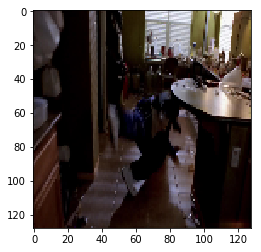

In [17]:
print(classes[y[0]])
plt.imshow(x[0][:,:,::-1])
plt.show()

In [18]:
import keras 

from keras.layers import Convolution2D, MaxPooling2D, Dense, Flatten

model = keras.Sequential()

model.add(Convolution2D(16, (3,3), padding="same", input_shape =[128, 128, 3], activation = "relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(32, (3,3), padding="same", activation = "relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(64, (3,3), padding="same", activation = "relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation ='relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [19]:
train_steps = len(train_ids) // batch_size 
valid_steps = len(valid_ids) // batch_size 

model.fit_generator(train_gen, validation_data= valid_gen, 
                    epochs = 3, steps_per_epoch = train_steps, validation_steps = valid_steps)

Epoch 1/3


ResourceExhaustedError: OOM when allocating tensor with shape[128,16,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node conv2d_5/convolution (defined at /home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3341)  = Conv2D[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_1/RMSprop/gradients/conv2d_5/convolution_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_5/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss_1/mul/_133}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_680_loss_1/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d_5/convolution', defined at:
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-7195704ae95b>", line 7, in <module>
    model.add(Convolution2D(16, (3,3), padding="same", input_shape =[128, 128, 3], activation = "relu"))
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/keras/models.py", line 497, in add
    layer(x)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3341, in conv2d
    data_format=tf_data_format)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 780, in convolution
    return op(input, filter)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 204, in __call__
    name=self.name)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 957, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128,16,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node conv2d_5/convolution (defined at /home/dell/anaconda3/envs/tf_py3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3341)  = Conv2D[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_1/RMSprop/gradients/conv2d_5/convolution_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_5/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss_1/mul/_133}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_680_loss_1/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

